# About

* Test accuracy and training time for *LogisticRegression*, *LinearSVC* and out nn.Module (*SentimentNN*).
* The ***sci-kit*** models optimized and fitted using *HalvingGridSearchCV*.
* User sentiment data produced my our *build_sentiment.ipynb*.

# Initialize

## Import functionality

In [1]:
import gc
import pickle
import warnings
from os.path import join
from time import time
from typing import Any

import numpy as np
import pandas as pd
import torch
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.svm import LinearSVC
from torch import nn, tensor
from torch.utils.data import DataLoader, Dataset

# Set device for torch.
device = torch.device('cuda')

## Load data

In [2]:
# Data set folder
SOURCE_DATA_FOLDER = ['..', 'datasets']
# Load the sample data generated in 'build_sentiment.ipynb'.
df_sentiment = pd.read_csv(join(*SOURCE_DATA_FOLDER, 'sentiment.csv'))
print('Rows:', df_sentiment.shape[0])


Rows: 21440


## Split data

In [3]:
# Split into features (X) and scores (y).
y_set = np.array(list(df_sentiment['SCORE']))
X_set = df_sentiment.to_numpy()[:, 1:]
# Split into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_set, y_set)

print('Train X/y:', X_train.shape, y_train.shape)
print('Test X/y:', X_test.shape, y_test.shape)

Train X/y: (16080, 492) (16080,)
Test X/y: (5360, 492) (5360,)


## Load classifier function

In [4]:
def load_or_calc(name: str, search: HalvingGridSearchCV, X: Any, y: Any) -> tuple[HalvingGridSearchCV, float]:
    """Calculator or load precalculated model.

    Args:
        name (str): _description_
        search (HalvingGridSearchCV): _description_
        X (Any): training featurtes
        y (Any): training labels

    Returns:
        tuple[HalvingGridSearchCV,float|None]: Return the loaded or calculated estimator and calculation time.
    """
    # Saved-state file
    fn = name+'.bin'
    try:
        # Try opening saverd state.
        with open(fn, 'rb') as f:
            return pickle.load(f)
    except:
        # Search best hyperparams.
        warnings.filterwarnings('ignore')
        start_time = time()
        search.fit(X, y)
        ellapsed = time()-start_time
        warnings.filterwarnings('default')
        # Save state
        with open(fn, 'wb') as f:
            pickle.dump((search, ellapsed), f)
        return (search, ellapsed)


# Optimize and Test

In [5]:
# Test statistics
METHODS = {}

## Optimize LogisticRegression

In [6]:
# Name
log_reg_name = 'LogisticRegression'
# Possible LogisticRegression parameters.
params = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.logspace(-4, 4, 10),
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter': [100, 1000, 2500, 5000]
}
# Parameter optimizer.
search = HalvingGridSearchCV(
    LogisticRegression(),
    param_grid=params,
    cv=5,
    random_state=int(time()),
    n_jobs=3,
    verbose=1)


In [7]:
# Calculate or load saved.
classifier, calc_time = load_or_calc(log_reg_name, search, X_train, y_train)


n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 66
max_resources_: 16080
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 720
n_resources: 66
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
----------
iter: 1
n_candidates: 240
n_resources: 198
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
----------
iter: 2
n_candidates: 80
n_resources: 594
Fitting 5 folds for each of 80 candidates, totalling 400 fits
----------
iter: 3
n_candidates: 27
n_resources: 1782
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 4
n_candidates: 9
n_resources: 5346
Fitting 5 folds for each of 9 candidates, totalling 45 fits


### Test

In [8]:
# Print best params
print('Estimator:', classifier.best_estimator_)
# Test accuracy
predicted = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)
# Store results
METHODS[log_reg_name] = {'est': str(
    classifier.best_estimator_), 'acc': accuracy, 'time': calc_time}


Estimator: LogisticRegression(C=0.3593813663804626, max_iter=5000, penalty='l1',
                   solver='saga')
Accuracy: 1.0


## Optimize LinearSVC

In [9]:
# Name
lsvc_name = 'LinearSVC'
# Possible LinearSVC parameters.
params = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.arange(0.01, 10, 1),
    'max_iter': [100, 1000, 2500, 5000]
}
# Parameter optimizer.
search = HalvingGridSearchCV(
    LinearSVC(),
    param_grid=params,
    cv=5,
    random_state=int(time()),
    n_jobs=3,
    verbose=1)


In [10]:
# Calculate or load saved.
classifier, calc_time = load_or_calc(lsvc_name, search, X_train, y_train)


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 198
max_resources_: 16080
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 160
n_resources: 198
Fitting 5 folds for each of 160 candidates, totalling 800 fits
----------
iter: 1
n_candidates: 54
n_resources: 594
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 2
n_candidates: 18
n_resources: 1782
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 3
n_candidates: 6
n_resources: 5346
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 4
n_candidates: 2
n_resources: 16038
Fitting 5 folds for each of 2 candidates, totalling 10 fits


### Test

In [11]:
# Print best params
print('Estimator:', classifier.best_estimator_)
# Test accuracy
predicted = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)
# Store results
METHODS[lsvc_name] = {'est': str(
    classifier.best_estimator_), 'acc': accuracy, 'time': calc_time}


Estimator: LinearSVC(C=0.01, max_iter=5000)
Accuracy: 0.9904850746268656


## Train Neural Net

In [38]:
# Name
nn_name = 'SentimentNN'


class SentimentNN(nn.Module):
    def __init__(self, num_features: int) -> None:
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
            nn.ReLU()
        )
        self.calc_time = 0

    def forward(self, x):
        return self.fc(x)

    def save(self, path: str) -> bool:
        try:
            torch.save(self.state_dict(), path)
            return True
        except:
            return False

    def load(self, path: str) -> bool:
        try:
            self.load_state_dict(torch.load(path))
            self.eval()
            return True
        except:
            return False

    def set_calc_time(self, ellapsed: float):
        self.calc_time = ellapsed

class SentimentData(Dataset):
    def __init__(self, X, y) -> None:
        self.X = X
        self.y = y

    def __getitem__(self, index) -> Any:
        return (
            torch.tensor(self.X[index], dtype=torch.float32, device=device),
            torch.tensor(self.y[index], dtype=torch.float32, device=device)
        )

    def __len__(self):
        return len(self.X)


In [40]:
model_file = 'SentimentNN.bin'
sentiment_model = SentimentNN(X_train.shape[1]).to(
    device=device, dtype=torch.float32)

# Split y into binary classes.
y_train_2 = []
for y_val in y_train:
    if y_val<0: y_train_2.append([1,0,0])
    elif y_val>0: y_train_2.append([0,0,1])
    else:y_train_2.append([0,1,0])
y_test_2 = []
for y_val in y_test:
    if y_val<0: y_test_2.append([1,0,0])
    elif y_val>0: y_test_2.append([0,0,1])
    else:y_test_2.append([0,1,0])

if not sentiment_model.load(model_file):
    # Data batching
    data_set = SentimentData(X_train, y_train_2)
    loader = DataLoader(data_set, batch_size=1024, shuffle=True)
    # create model
    sentiment_model = SentimentNN(X_train.shape[1]).to(
        device=device, dtype=torch.float32)
    # create optimizer cunction
    optimizer = torch.optim.Adam(sentiment_model.parameters())
    # create loss function
    criterion = nn.MSELoss()
    # set passes
    passes = 200
    start_time = time()
    # do training iterations
    for epoch in range(passes):
        # reset gradients
        optimizer.zero_grad()
        # batch load data each pass
        for X_, y_ in loader:
            # prediction
            predicted = sentiment_model(X_).reshape(y_.shape)
            # calculate cost
            loss = criterion(predicted, y_)
            # calculate gradients
            loss.backward()
            # update nn weights
            optimizer.step()
            # try to save memory
            gc.collect()
            torch.cuda.empty_cache()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: loss={loss}')
    sentiment_model.set_calc_time(time() - start_time)
    print(f'Last epoch {epoch}: loss={loss}')
    # save results to file
    sentiment_model.save(model_file)

Epoch 0: loss=0.21813973784446716
Epoch 10: loss=0.04732459783554077
Epoch 20: loss=0.021799582988023758
Epoch 30: loss=0.0035594087094068527
Epoch 40: loss=0.0010870894184336066
Epoch 50: loss=0.0025552897714078426
Epoch 60: loss=0.0028518910985440016
Epoch 70: loss=0.009018616750836372
Epoch 80: loss=0.003901192918419838
Epoch 90: loss=0.0048492541536688805
Epoch 100: loss=0.003562967060133815
Epoch 110: loss=0.0009323271224275231
Epoch 120: loss=0.0005173568497411907
Epoch 130: loss=0.0008533788495697081
Epoch 140: loss=0.0008678986923769116
Epoch 150: loss=0.0038814556319266558
Epoch 160: loss=0.12626464664936066
Epoch 170: loss=0.0009080074960365891
Epoch 180: loss=0.00024504197062924504
Epoch 190: loss=0.00011664656631182879
Last epoch 199: loss=6.252589082578197e-05


### Test

In [41]:
# Test accuracy
predicted = sentiment_model(tensor(X_test, device=device, dtype=torch.float32))
predicted = predicted.cpu().detach().numpy()
accuracy = np.amax(predicted*y_test_2,axis=1).sum() / predicted.shape[0]
print('Accuracy:', accuracy)
# Store results
METHODS[nn_name] = {'est': f'SentimentNN({X_train.shape[1]},{256},{128})',
                    'acc': accuracy, 'time': sentiment_model.calc_time}

Accuracy: 0.9944984027587656


# Conclusion


Estimator accuracy and time comparison
       Estimator: LogisticRegression(C=0.3593813663804626, max_iter=5000, penalty='l1',
                   solver='saga')
       Accuracvy: 100.0 %
Calculation time: 1383.9 s
------------------------------------------------------------
       Estimator: LinearSVC(C=0.01, max_iter=5000)
       Accuracvy: 99.0 %
Calculation time: 5.7 s
------------------------------------------------------------
       Estimator: SentimentNN(492,256,128)
       Accuracvy: 99.4 %
Calculation time: 652.1 s
------------------------------------------------------------


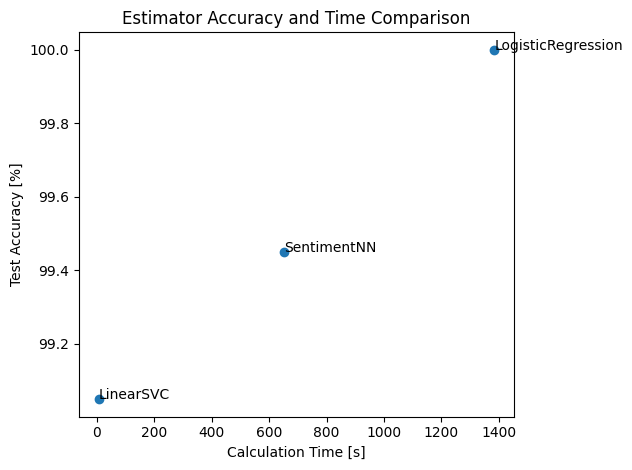

In [42]:
from matplotlib import pyplot as plt
# Plot datasets
est_labels = []
est_acc = []
est_time = []
# Print as table
print('''
============================================================
Estimator accuracy and time comparison
============================================================''')
for k, method in METHODS.items():
    print(f'''       Estimator: {method['est']}
       Accuracvy: {method['acc']*100:.1f} %
Calculation time: {method['time']:.1f} s
------------------------------------------------------------''')
    est_labels.append(k)
    est_acc.append(method['acc']*100)
    est_time.append(method['time'])
# Plot
plt.scatter(est_time, est_acc)
plt.xlabel('Calculation Time [s]')
plt.ylabel('Test Accuracy [%]')
plt.title('Estimator Accuracy and Time Comparison')
for i, txt in enumerate(est_time):
    plt.annotate(est_labels[i], (est_time[i], est_acc[i]))
plt.tight_layout()

## Choice of algorithm

All of the above have good accuracy and the logistic regression has a suspicious 100% accuracy,
but let's pretend that is true. I.e, we pick ***logistic regression*** for this task.

The logistic regression calculation time was a hefty 1384s for our data set.
If the data set had been of real world size then I would have gone for support vector instead,
because of the very fast training time.

Neural network would have been a good candidate if we were going to use numeric predictions,
i.e. not only classify but see how strong the classification was.

NOTES
I only did 200 epocs on the NN to save time. It could possibly be on par with logistic regression
results, but we will leave is as-is for now.